In [1]:
def get_ytw_from_date(start='1990-01-31', end='2019-07-31', srcfile=r'YTW-All-Values.xlsx'):
    '''
    
    load data from source file into dataframe
    columns:
        Corp - corporate bond rate
        TB - treasury bond rate
        CS - credit spread
        Econ - economic data
    '''
    import pandas as pd
    import cs_logger as cslog

    source_file = srcfile
    src_file = pd.read_excel(source_file, sheet_name='data', header=0, index_col='Date')
    ytw_df = pd.DataFrame(src_file)
    ytw_df = ytw_df.asfreq(pd.infer_freq(ytw_df.index)) # infer data frequency; monthly
    
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    ytw_df = ytw_df[start_date:end_date]    # filter records by date

    cslog.debug(f"df: {ytw_df.head()}")
    return ytw_df

In [3]:
# total range: 1988-08-31 to 2019-12-31
# analysis range: 1990-01-31 to 2019-07-31
# training: 2017-01-01 to 2017-12-31
# predict: 2018-01-01 to 2018-12-31 

# analysis range: 2009-01-31 to 2019-07-31
# training: 2017-01-01 to 2017-12-31
# predict: 2018-01-01 to 2018-12-31

ytw = get_ytw_from_date(start='2009-01-31', srcfile='YTW-All-Values.xlsx')
print(ytw.shape)

(127, 28)


In [39]:
# CS-Aaa-3MO	 CS-Aa-3MO	 CS-A-3MO	 CS-Baa-3MO	 CS-Aaa-1YR	 CS-Aa-1YR	 CS-A-1YR	 CS-Baa-1YR	 CS-Aaa-5YR	 CS-Aa-5YR	 CS-A-5YR	 CS-Baa-5YR

# cs_ytw = run_arma(column=column, csdata=ytw, arma_order=order)
# print(cs_ytw.summary())

In [82]:
from statsmodels.tsa.arima_model import ARMA

# total range: 1988-08-31 to 2019-12-31
# analysis range: 1990-01-31 to 2019-07-31
# training: 2017-01-01 to 2017-12-31
# predict: 2018-01-01 to 2018-12-31 

column = 'CS-Aaa-3MO'
order = (3, 0)

training = get_ytw_from_date(start='2017-01-01', end='2017-12-31')  # training data

# training = training[column]
# print(training.shape)
# print(training.head)
pre_start, pre_end = '2018-01-01', '2018-12-31'
actual = get_ytw_from_date(start=pre_start, end=pre_end)

test_data = get_ytw_from_date(start=pre_start, end=pre_end) # test data to predict
# test_data = test_data[column]
# print(test_data.head)
# print(test_data.shape)

# run arma

train = ARMA(endog=training[column], order=order).fit(start_params=None, trend='c', start_ar_lags=None)

# print actual
print(actual[column].head)

# predict
predict = train.predict(start=pre_start, end=pre_end)
print(predict)

res = test_data[column] - predict
print(res)


<bound method NDFrame.head of Date
2018-01-31    1.744
2018-02-28    1.763
2018-03-31    1.640
2018-04-30    1.674
2018-05-31    1.516
2018-06-30    1.593
2018-07-31    1.484
2018-08-31    1.405
2018-09-30    1.445
2018-10-31    1.493
2018-11-30    1.408
2018-12-31    1.090
Freq: M, Name: CS-Aaa-3MO, dtype: float64>
2018-01-31    1.545722
2018-02-28    1.480919
2018-03-31    1.470356
2018-04-30    1.468900
2018-05-31    1.498564
2018-06-30    1.542019
2018-07-31    1.603925
2018-08-31    1.675985
2018-09-30    1.757217
2018-10-31    1.842527
2018-11-30    1.929447
2018-12-31    2.014424
Freq: M, dtype: float64
Date
2018-01-31    0.198278
2018-02-28    0.282081
2018-03-31    0.169644
2018-04-30    0.205100
2018-05-31    0.017436
2018-06-30    0.050981
2018-07-31   -0.119925
2018-08-31   -0.270985
2018-09-30   -0.312217
2018-10-31   -0.349527
2018-11-30   -0.521447
2018-12-31   -0.924424
Freq: M, dtype: float64


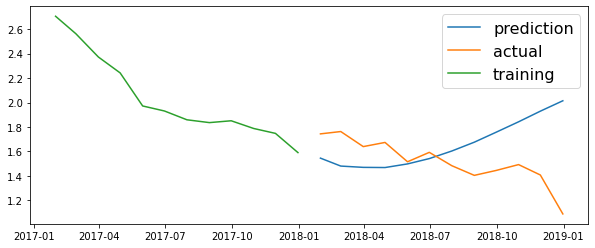

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))

plt.clf()
# plt.title(column, fontsize=20)
plt.plot(predict)
# plt.plot(test_data[column])
plt.plot(actual[column])
plt.plot(training[column])
plt.legend(('prediction', 'actual', 'training'), fontsize=16)


In [80]:
from statsmodels.stats.stattools import jarque_bera
score, pvalue, _, _ = jarque_bera(res)

if pvalue < 0.05:
   print ('residuals may NOT be normally distributed.', pvalue)
else:
    print ('residuals seem to be normally distributed.', pvalue)

The residuals seem normally distributed. 0.5159922127843919
